# 100% RE by 2050 and the Effects of Lifetime and Recycling

Comparison case using the functions in PV ICE to compare how PV module lifetime and PV module recycling effect the energy transition to 100% clean energy by 2050.





![Folder 15 vs 50 year Module](../images_wiki/2_15vs50Overview.PNG)

WORDS WORDS WORDS


In [1]:
import PV_ICE
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

import os
from pathlib import Path

PV_ICE.__version__

'v0.2.0+94.g1ab51c9.dirty'

In [2]:
testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'SFs_LifeVSRecycle')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
materialsfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
print ("Your simulation will be stored in %s" % testfolder)
print("Your simulation input data will be written/read from %s" % inputfolder)
print("Material files will be from %s" % materialsfolder)

Your simulation will be stored in C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle
Your simulation input data will be written/read from C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP
Material files will be from C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\baselines


In [3]:
if not os.path.exists(testfolder):
    os.makedirs(testfolder)

# File Preparation

First, we load the Module Baseline. Will be used later to populate all the columns other than 'new_Installed_Capacity_[MW]' which will be supplied by the REEDS model. Unlike the SF simulations, this analysis will use PV ICE developed baselines.

NOTE: this section of code should only need to be run once to populate data, and again anytime the ReeDS file is updated.

In [ ]:
rtest = PV_ICE.Simulation(name='Sim1', path=inputfolder)
rtest.createScenario(name='test', file=r'..\baselines\baseline_modules_US.csv')
baseline = rtest.scenario['test'].data
baseline = baseline.drop(columns=['new_Installed_Capacity_[MW]'])
baseline.set_index('year', inplace=True)
baseline.index = pd.PeriodIndex(baseline.index, freq='A')  # A -- Annual
#baseline.head(5)

Drop 1995 through 2009 because SF projections begin in 2010. Technically this neglects ~1.5 GW of installs from 1995 through 2009.

In [ ]:
baseline.drop(baseline.loc['1995':'2009'].index, inplace=True)

Now we load the ReEDS simulation output, i.e. the Solar Futures projections with PCA regions, States, and Scenarios. Note that this is stored outside of the PV ICE folder and therefore not publicly available on github

In [ ]:
reedsFile = str(Path().resolve().parent.parent.parent / 'December Core Scenarios ReEDS Outputs Solar Futures v3a.xlsx')
print ("Input file is stored in %s" % reedsFile)

In [ ]:
REEDSInput = pd.read_excel(reedsFile, sheet_name="new installs PV")
#NEED TO CHECK THAT AC to DC has been taken care of in excel file (there is a multiplier, is set to 1)

First create a copy which groups the data by PCA region

In [ ]:
rawdf = REEDSInput.copy()
rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True) #tech=pvtotal from "new installs PV sheet", so can drop
rawdf.set_index(['Scenario','Year','PCA'], inplace=True)

For each Scenario and for each PCA, combine with baseline and save as input file. This will be in a folder PCAs under the simulation folder in TEMP

In [ ]:
for ii in range (len(rawdf.unstack(level=1))):
    PCA = rawdf.unstack(level=1).iloc[ii].name[1]
    SCEN = rawdf.unstack(level=1).iloc[ii].name[0]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_'+PCA +'.csv'
    subtestfolder = os.path.join(testfolder, 'PCAs')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    A = rawdf.unstack(level=1).iloc[ii]
    A = A.droplevel(level=0)
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
   
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
    "mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
    "mod_Repair,mod_MerchantTail,mod_Reuse\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

For each Scenario and each State, combine with baseline file and save as input file. This will be in a folder States under the simulation folder in TEMP

In [ ]:
rawdf = REEDSInput.copy()
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year','PCA', 'State'], inplace=True)

In [ ]:
df = rawdf.groupby(['Scenario','State', 'Year'])['Capacity (GW)'].sum()
df = pd.DataFrame(df)

In [ ]:
for ii in range (len(df.unstack(level=2))):   
    STATE = df.unstack(level=2).iloc[ii].name[1]
    SCEN = df.unstack(level=2).iloc[ii].name[0]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_'+STATE +'.csv'
    
    subtestfolder = os.path.join(testfolder, 'States')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)

    A = df.unstack(level=2).iloc[ii]
    A = A.droplevel(level=0)
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85 # marketshares['Si']
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
    
    
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
    "mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
    "mod_Repair,mod_MerchantTail,mod_Reuse\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

Finally, make an overall US baseline which ignores PCA regions and states. This is useful for speeding the simulation.

In [ ]:
rawdf = REEDSInput.copy()
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year'], inplace=True)

In [ ]:
df = rawdf.groupby(['Scenario','Year'])['Capacity (GW)'].sum()

In [ ]:
for ii in range (len(df.unstack(level=1))):
    SCEN = df.unstack(level=1).index[ii]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'.csv'
    
    subtestfolder = os.path.join(testfolder, 'USA')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    
    A = df.unstack(level=1).iloc[ii]

    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85 # marketshares['Si']
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
   
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
    "mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
    "mod_Repair,mod_MerchantTail,mod_Reuse\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

# Analysis

Collect all the scenario names and downselect to the scenario(s) of interest. In this case, we are only concerned with the highest capacity and deployment rate, Decarbonization + Electrification (Decarb+E)

In [4]:
scenarios = ['Reference.Mod',
 'Reference.Adv',
 'Reference.Adv_DR',
 '95-by-35.Mod',
 '95-by-35.Adv',
 '95-by-35.Adv_DR',
 '95-by-35_Elec.Mod',
 '95-by-35_Elec.Adv',
 '95-by-35_Elec.Adv_DR']

SFscenarios = ['95-by-35_Elec.Adv_DR'] #Decarb+E
SFscenarios

['95-by-35_Elec.Adv_DR']

In [5]:
#add materials for simulation
MATERIALS = ['glass','aluminium_frames','silicon','silver', 'copper', 'encapsulant', 'backsheet']

Set up the PV ICE simulation with scenario and materials

In [90]:
r1 = PV_ICE.Simulation(name='SF-LvR', path=testfolder) #create simulation r1
#baselinefolder = r'..\baselines'    

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    r1.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    r1.scenario['Decarb+E_PVICE_defaults'].addMaterials(MATERIALS)  # baselinefolder=baselinefolder)
    r1.trim_Years(startYear=2010)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle
endYear not provided. Setting to end year of Module data 2050


Run the simulation

In [8]:
r1.calculateMassFlow()

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


In [8]:
r1.scenario['Decarb+E_PVICE_defaults'].material['glass'].materialdata.tail(5)

,year,mat_virgin_eff,mat_massperm2,mat_MFG_eff,mat_MFG_scrap_Recycled,mat_MFG_scrap_Recycling_eff,mat_MFG_scrap_Recycled_into_HQ,mat_MFG_scrap_Recycled_into_HQ_Reused4MFG,mat_EOL_collected_Recycled,mat_EOL_Recycling_eff,...,mat_MFG_Recycled_into_HQ,mat_MFG_Recycled_into_OQ,mat_MFG_Recycled_HQ_into_MFG,mat_MFG_Recycled_HQ_into_OU,mat_Virgin_Stock,mat_Virgin_Stock_Raw,mat_Total_EOL_Landfilled,mat_Total_MFG_Landfilled,mat_Total_Landfilled,mat_Total_Recycled_OU
36,2046,99.9,10120.275,99.0,80.0,50.0,20.0,10.0,90.0,40.0,...,7.225230e+09,2.890092e+10,7.225230e+08,6.502707e+09,3.029865e+12,3.032898e+12,4.901762e+11,5.418922e+10,5.443654e+11,4.609532e+10
37,2047,99.9,10120.275,99.0,80.0,50.0,20.0,10.0,90.0,40.0,...,4.270160e+09,1.708064e+10,4.270160e+08,3.843144e+09,1.790658e+12,1.792451e+12,3.361362e+11,3.202620e+10,3.681624e+11,2.825557e+10
38,2048,99.9,10120.275,99.0,80.0,50.0,20.0,10.0,90.0,40.0,...,4.260431e+09,1.704172e+10,4.260431e+08,3.834388e+09,1.786574e+12,1.788363e+12,3.510345e+11,3.195323e+10,3.829877e+11,2.853285e+10
39,2049,99.9,10120.275,99.0,80.0,50.0,20.0,10.0,90.0,40.0,...,6.976729e+09,2.790692e+10,6.976729e+08,6.279056e+09,2.925661e+12,2.928589e+12,4.609206e+11,5.232547e+10,5.132460e+11,4.423954e+10
40,2050,99.9,10120.275,99.0,80.0,50.0,20.0,10.0,90.0,40.0,...,6.961875e+09,2.784750e+10,6.961875e+08,6.265688e+09,2.919451e+12,2.922374e+12,3.859960e+11,5.221406e+10,4.382100e+11,4.253251e+10


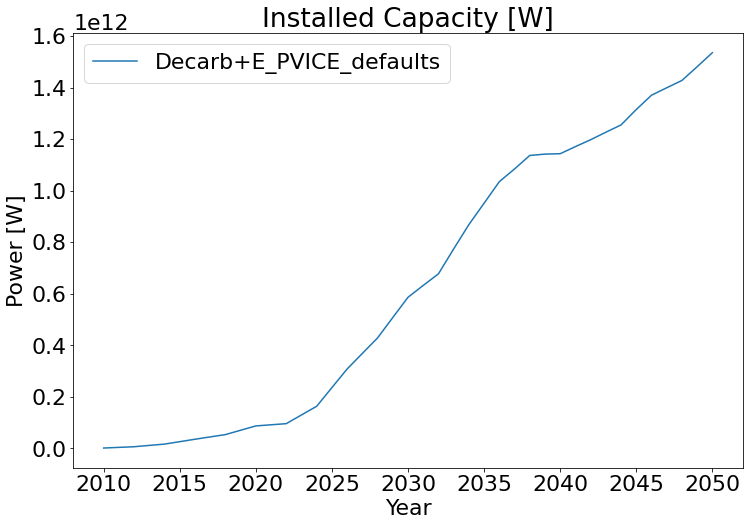

In [9]:
r1.plotScenariosComparison('Installed_Capacity_[W]')

## Lifetime and Recycling Scenario Creation

The range of potential future technology directions for PV will be explored in terms of module lifetime and EoL recycling rates. Currently technology is ~32 year module with a 6% EoL recycling rate (15% collection, 40% modules sent to recycling). Lifetimes could improve, with 50 years targeted by DOE SETO. And or recycling rates could improve, as modeled by CdTe management from First Solar or perovskite technology. This analysis will explore on a mass flow basis, which of these two circular economy levers is most important research priority for achieving the energy transition while minimizing waste and material extraction.

We will explore from a 15 year module lifetime to a 50 year module lifetime, and from 0% recycled to 100% recycled.

### Create lifetime and recycling ranges

In [9]:
Lifetime_Range = pd.concat([pd.Series(range(15,30,3)),pd.Series(range(30,51,2))]) #this absolute lifetime values
Lifetime_Range.reset_index(inplace=True, drop=True)
Lifetime_Diff30 = Lifetime_Range-30
Degradation_Range = pd.Series([1.470, 1.220, 1.050, 0.920, 0.820, 0.740, 0.690, 0.650, 0.615, 0.582, 0.555, 0.525, 0.505, 0.480, 0.460, 0.445])
Recycling_Range = pd.Series(range(0,105,5)) # this is absolute recycling values from 0-100
#print(Lifetime_Range)
#print(Degradation_Range)
#print(Recycling_Range)

In [10]:
#list of material recycling variables
RecyclingPaths = ['mat_MFG_scrap_Recycled', 'mat_MFG_scrap_Recycled_into_HQ', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 
                  'mat_EOL_collected_Recycled', 'mat_EOL_Recycled_into_HQ', 'mat_EOL_RecycledHQ_Reused4MFG']
RecyclingYields = ['mat_MFG_scrap_Recycling_eff', 'mat_EOL_Recycling_eff']

Now some magic to automatically generate T50 and T90 values for each lifetime

In [11]:
#create linear regression for mod_reliability_t50 & mod_reliability_t90 vs. mod_lifetime 
#to estimate t50 and t90 values to input for improved lifetime scenario
reliability_baselines = pd.DataFrame()
reliability_baselines['mod_lifetime'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_lifetime']
reliability_baselines['mod_reliability_t50'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_reliability_t50']
reliability_baselines['mod_reliability_t90'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_reliability_t90']

In [12]:
X_lifetime = reliability_baselines.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y1_t50 = reliability_baselines.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y2_t90 = reliability_baselines.iloc[:, 2].values.reshape(-1, 1)
range_lifetimes = np.array(Lifetime_Range).reshape(-1,1)

from sklearn.linear_model import LinearRegression
from itertools import chain

linear_regressor_Y1 = LinearRegression()
linear_regressor_Y1.fit(X_lifetime, Y1_t50)  # perform linear regression
t50_list = linear_regressor_Y1.predict(range_lifetimes).tolist()  # make predictions based on improved lifetime values
t50_list = list(chain(*t50_list)) #unnest list
t50_range_simple = pd.Series([ '%.2f' % elem for elem in t50_list ])

linear_regressor_Y2 = LinearRegression() 
linear_regressor_Y2.fit(X_lifetime, Y2_t90)
t90_list = linear_regressor_Y2.predict(range_lifetimes).tolist()
t90_list = list(chain(*t90_list)) #unnest list
t90_range_simple = pd.Series([ '%.2f' % elem for elem in t90_list ])

In [13]:
#create a tidy dataframe summarizing all the lifetime, degradation, reliability values
lifetime_range_df = pd.concat([Lifetime_Range, Degradation_Range, t50_range_simple, t90_range_simple], axis=1)
lifetime_range_df.columns = 'mod_lifetime', 'mod_degradation', 't50', 't90'
print(lifetime_range_df)

    mod_lifetime  mod_degradation    t50    t90
0             15            1.470  13.95  19.78
1             18            1.220  17.56  23.15
2             21            1.050  21.17  26.53
3             24            0.920  24.78  29.90
4             27            0.820  28.39  33.28
5             30            0.740  32.00  36.65
6             32            0.690  34.41  38.90
7             34            0.650  36.81  41.15
8             36            0.615  39.22  43.40
9             38            0.582  41.63  45.65
10            40            0.555  44.03  47.90
11            42            0.525  46.44  50.15
12            44            0.505  48.85  52.40
13            46            0.480  51.25  54.65
14            48            0.460  53.66  56.90
15            50            0.445  56.07  59.15


In [14]:
#drop some of the higher lifetime values due to small value add and graphing
unnecessary = [48,46,42,38,34]
lifetime_range_df = lifetime_range_df[lifetime_range_df.mod_lifetime.isin(unnecessary)==False]
print(lifetime_range_df)

    mod_lifetime  mod_degradation    t50    t90
0             15            1.470  13.95  19.78
1             18            1.220  17.56  23.15
2             21            1.050  21.17  26.53
3             24            0.920  24.78  29.90
4             27            0.820  28.39  33.28
5             30            0.740  32.00  36.65
6             32            0.690  34.41  38.90
8             36            0.615  39.22  43.40
10            40            0.555  44.03  47.90
12            44            0.505  48.85  52.40
15            50            0.445  56.07  59.15


### Create all Scenarios
Now with the lifetime and recycling ranges defined, create a scenario for each combination

Notes:
- recycling values are set to closed loop, with XX% material recycling yields assuming 100% collection of modules and materials


In [89]:
#these scenarios are being added onto the Decarb+E_PVICE_Default scenario
#All combinations of recycling and lifetime
for life in range(0,len(Lifetime_Range)): #loop over lifetimes
    for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
        scenname = str(Lifetime_Range[life])+'years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
        r1.createScenario(name=scenname,file=modulefile) #create the scenario with name
        r1.scenario[scenname].addMaterials(MATERIALS)  # baselinefolder=baselinefolder)
        r1.trim_Years(startYear=2010, endYear=2050)
        r1.modifyScenario(scenname, 'mod_lifetime', Lifetime_Range[life], 2020)
        r1.modifyScenario(scenname, 'mod_reliability_t50', float(t50_range_simple[life]), 2020)
        r1.modifyScenario(scenname, 'mod_reliability_t90', float(t90_range_simple[life]), 2020)
        r1.modifyScenario(scenname, 'mod_degradation', Degradation_Range[life], 2020)
        r1.modifyScenario(scenname, 'mod_EOL_collected_recycled', 100.0, 2020)
        r1.modifyScenario(scenname, 'mod_EOL_collection_eff', 100.0, 2020)      
        
        for var in range(0,len(RecyclingPaths)):
            r1.scenario[scenname].modifyMaterials(MATERIALS, stage=RecyclingPaths[var], value=100.0, start_year=2020)

        for ylds in range(0,len(RecyclingYields)):
            r1.scenario[scenname].modifyMaterials(MATERIALS, stage=RecyclingYields[ylds], value=Recycling_Range[recycle], start_year=2020)

KeyboardInterrupt: 

In [ ]:
r1.scenario['Decarb+E_PVICE_defaults'].data.head(15)

In [ ]:
r1.scenario['15years & 0% Recycled'].data.head(15)

In [ ]:
r1.scenario['50years & 0% Recycled'].data.head(15)

In [ ]:
r1.scenario['50years & 0% Recycled'].material['glass'].materialdata.head(15)

In [ ]:
print(len(r1.scenario.keys()))

In [ ]:
r1.calculateMassFlow()

In [ ]:
r1.plotScenariosComparison('Installed_Capacity_[W]')

In [ ]:
r1.plotMaterialComparisonAcrossScenarios(material='glass', keyword='mat_Total_Landfilled')

Use the PV ICE "aggregate results" function to print out a table of Virgin Material Demands, Lifecycle Wastes (MFG, EoL, both), new installed capacity and effective cumulative capacity, both annually and cumulatively.

In [ ]:
yearlyRvL_identinstall, cumRvL_identinstall = r1.aggregateResults()
yearlyRvL_identinstall.tail(5)

In [ ]:
yearlyRvL_identinstall.to_csv(os.path.join(testfolder,'yearlyRvL-identinstall.csv'))
cumRvL_identinstall.to_csv(os.path.join(testfolder,'cumulativeRvL-identinstall.csv'))

#### Heat Map - Identical Installs

Read the aggregated results back into the journal from csvs (run time on simulations can be long)

In [16]:
yearlyRvL_identinstall = pd.read_csv(os.path.join(testfolder,'yearlyRvL-identinstall.csv'), index_col='year')
cumRvL_identinstall = pd.read_csv(os.path.join(testfolder,'cumulativeRvL-identinstall.csv'), index_col='year')

In [17]:
#make a dataframe to become the multiIndex for heat map creation
lifeRecycIndex = pd.DataFrame(columns = ['Life','Recycling'])
for life in range(0,len(Lifetime_Range)): #loop over lifetimes
    for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
        toappend = pd.DataFrame([[Lifetime_Range[life],Recycling_Range[recycle]]], columns=('Life', 'Recycling'))
        lifeRecycIndex = pd.concat([lifeRecycIndex, toappend])
pvice_index = pd.DataFrame([['pvice','pvice']], columns=('Life', 'Recycling'))
lifeRecycIndex_complete = pd.concat([pvice_index,lifeRecycIndex])

In [ ]:
#ii = indentical installs
#manipulate dataframes for the heat map form, waste & virgin
heatmap_cums = cumRvL_identinstall.copy()
#filter down to "waste all module" and "virgin stock module"
heatmap_cums_modulewaste = heatmap_cums.filter(regex='WasteAll_Module')
heatmap_cums_virgindemand = heatmap_cums.filter(regex='VirginStock_Module')

#Combine the multi index and heatmap data
#transpose the dataframe, moving columns to the index
heatmap_cums_modulewaste_twist = heatmap_cums_modulewaste.T 
heatmap_cums_virgindemand_twist = heatmap_cums_virgindemand.T
#Wastes
lifeRecycIndex_complete.index= heatmap_cums_modulewaste_twist.index #make index match for join
module_waste_heatmapdata = lifeRecycIndex_complete.join(heatmap_cums_modulewaste_twist) #join dataframes
module_waste_heatmapdata.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking
#Virgin demands
lifeRecycIndex_complete.index= heatmap_cums_virgindemand_twist.index #make index match for join
virgin_material_heatmapdata = lifeRecycIndex_complete.join(heatmap_cums_virgindemand_twist) #join dataframes
virgin_material_heatmapdata.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking

#create subset data of just 2050 cumulative wastes
modulewaste_heatmap_tonnes = pd.DataFrame(module_waste_heatmapdata[2050]) #select only 2050 cumulative values
modulewaste_heatmap = modulewaste_heatmap_tonnes/1e6 #convert to million metric tonnes
heatdata_Waste_pivot_orig = modulewaste_heatmap.unstack(level=0) #compare recycling vs lifetime
heatdata_Waste_pivot_ii = heatdata_Waste_pivot_orig[::-1] #reverse the order of recycling rate

#create subset data of just 2050 cumulative virgin demands
virgin_mat_demand_tonnes = pd.DataFrame(virgin_material_heatmapdata[2050]) #select only 2050 - need to improve to remove label
virgin_mat_demand = virgin_mat_demand_tonnes/1e6 #convert to million metric tonnes
heatdata_virgin_pivot_orig = virgin_mat_demand.unstack(level=0) #pivot
heatdata_Virgin_pivot_ii = heatdata_virgin_pivot_orig[::-1] #reverse order of recycling rate

In [ ]:
print('Minimum waste is '+str(round(np.min(heatdata_Waste_pivot_ii).min(),0))+' million metric tonnes')
print('Maximum waste is '+str(round(np.max(heatdata_Waste_pivot_ii).max(),0))+' million metric tonnes')
print('Minimum virgin is '+str(round(np.min(heatdata_Virgin_pivot_ii).min(),0))+' million metric tonnes')
print('Maximum virgin is '+str(round(np.max(heatdata_Virgin_pivot_ii).max(),0))+' million metric tonnes')


In [ ]:
#Make heat maps with cumulative data
import seaborn as sns
plt.style.use("seaborn")

#plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (10, 18)
fig,ax = plt.subplots(2, 1)
sns.set(font_scale=1.5)
color = plt.get_cmap('coolwarm')
color.set_bad('white')

#Wastes
plt.subplot(2,1,1)
sns.heatmap(heatdata_Waste_pivot_ii, annot = False, 
            cmap='coolwarm', #sns.diverging_palette(220, 20, n=200), 
            vmin= 0.0, #(np.min(heatdata_Waste_pivot_ii).min()),
            vmax= 100.0, #(np.max(heatdata_Waste_pivot_ii).max()),  #using same scale as cc below
            center = 9.959196 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Lifecycle Wastes by 2050 [Million Metric Tonnes]'})
plt.title('Lifecycle Wastes')
plt.ylabel('Recycling Rate (%)')
plt.xlabel('Lifetime (years)')
plt.yticks(rotation=0)
#plt.xticks(fontsize=14)
#

#Virgin Demands
plt.subplot(2,1,2)
sns.heatmap(heatdata_Virgin_pivot_ii, annot = False,
           cmap='coolwarm', #sns.diverging_palette(220, 20, n=200), 
            vmin= 20.0, #(np.min(heatdata_Virgin_pivot_ii).min()),
            vmax= 180.0, #(np.max(heatdata_Virgin_pivot_ii).max()), #using max cc below
            center=96.685293, #fix to be dynamic
           cbar_kws={'label': 'Virgin Material Demands by 2050 [Million Metric Tonnes]'})
plt.title('Virgin Demands')
plt.ylabel('Recycling Rate (%)')
plt.xlabel('Lifetime (years)')
plt.yticks(rotation=0)
#plt.xticks(fontsize=14)

#Installed Capacity
#plt.subplot(3,1,3)
#sns.heatmap(heatdata_InstalledCap_pivot, annot = False,
#           cmap=sns.diverging_palette(20, 220, n=200), 
#            vmin=-70.0, vmax=10.0, center=0, square=True)
#plt.title('Installed Capacity')
#plt.xlabel('Recycling Rate')
#plt.yticks(rotation=0)

fig.suptitle('2050 Cumulative Wastes and Material Demands:\n Identical Installs', fontsize=22, x=0.45)
plt.subplots_adjust(top=0.9)
fig.tight_layout(h_pad=1)
# set the spacing between subplots
#plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)


plt.savefig('heatmap-identicalInstalls.png')
plt.show()

#### Pie chart of Lifecycle Wastes in 2050, PV ICE scenario

In [ ]:
pvice_cums = cumRvL_identinstall.filter(like='Decarb+E_PVICE_defaults')
pvice_cumwastes = pvice_cums.filter(regex='WasteAll')
pvice_2050_cumwastes = pd.DataFrame(pvice_cumwastes.loc[2050])
pvice_2050_cumwastes.to_csv(os.path.join(testfolder,'PVICE_cumulativeWastes2050_pieChart.csv'))

## Installation Compensation Calculation

NOTE: this mass flow calculation takes a LONG time to run, recommend leaving it overnight. A csv of the yearly and cumulative aggregated results is saved as csv and read back in to speed analysis and graphing.

In [ ]:

for row in range (0,len(r1.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(r1.scenario.keys())):
        scen = list(r1.scenario.keys())[scenario]
        Under_Installment = ( (r1.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               r1.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        r1.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    r1.calculateMassFlow()


In [ ]:
yearlyRvL_installcomp, cumRvL_installcomp = r1.aggregateResults()
yearlyRvL_installcomp.to_csv(os.path.join(testfolder,'yearlyRvL-installcomp.csv'))
cumRvL_installcomp.to_csv(os.path.join(testfolder,'cumulativeRvL-installcomp.csv'))

Read the csvs back in for plotting (installation compensation calc runs a LONG time).

In [206]:
yearlyRvL_installcomp = pd.read_csv(os.path.join(testfolder,'yearlyRvL-installcomp.csv'), index_col='year')
cumRvL_installcomp = pd.read_csv(os.path.join(testfolder,'cumulativeRvL-installcomp.csv'), index_col='year')

#### Bar chart of additional installations

In [74]:
singleLifeRange = cumRvL_installcomp.filter(like='95%') #select a single lifetime of each
newinstallsedofSingleLifeRange = singleLifeRange.filter(regex='newInstalledCapacity') #select for new installs
LifeRange_installsComped = pd.DataFrame(newinstallsedofSingleLifeRange.loc[2050]) #select only the 2050 cumulatives
LifeRange_installsComped.set_index(Lifetime_Range, inplace=True) #set the index to the lifetime range for label ease
LifeRange_installsComped_TW = LifeRange_installsComped/1e6 #convert to TW

pvice_newinstalls = cumRvL_installcomp.filter(like='newInstalledCapacity_SF-LvR_Decarb+E_PVICE_defaults')
pvice_newinstalls_2050 = pvice_newinstalls.loc[2050].values
pvice_newinstalls_TW = pvice_newinstalls_2050/1e6
#pvice_newinstalls_TW.columns = LifeRange_installsComped_TW.columns
LifeRange_installsComped_TW_relative = LifeRange_installsComped_TW-pvice_newinstalls_TW

LifeRange_installsComped_TW_relative.to_csv(os.path.join(testfolder,'AddedReqInstalls-BarChartData.csv'))

<AxesSubplot:>

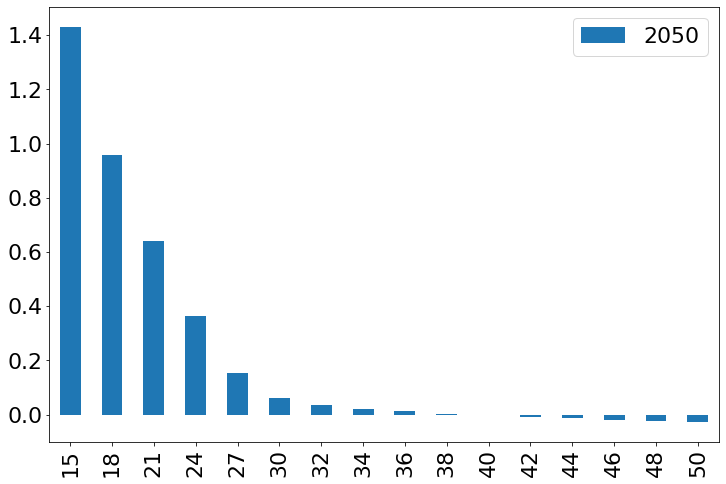

In [75]:
LifeRange_installsComped_TW_relative.plot(kind='bar')

#### Heat Map - Compensated Installs

In [ ]:
#cc = compensated capacity
#manipulate dataframes for the heat map form, waste & virgin
heatmap_cums_cc = cumRvL_installcomp.copy()
#filter down to "waste all module"
heatmap_cums_modulewaste_cc = heatmap_cums_cc.filter(regex='WasteAll_Module')
heatmap_cums_virgindemand_cc = heatmap_cums_cc.filter(regex='VirginStock_Module')

#Combine the multi index and heatmap data
heatmap_cums_modulewaste_twist_cc = heatmap_cums_modulewaste_cc.T #transpose the dataframe
heatmap_cums_virgindemand_twist_cc = heatmap_cums_virgindemand_cc.T

#create subset data of just 2050 cumulative wastes
lifeRecycIndex_complete.index= heatmap_cums_modulewaste_twist_cc.index #make index match for join
module_waste_heatmapdata_cc = lifeRecycIndex_complete.join(heatmap_cums_modulewaste_twist_cc) #join dataframes
module_waste_heatmapdata_cc.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking
modulewaste_heatmap_tonnes_cc = pd.DataFrame(module_waste_heatmapdata_cc[2050]) #select only 2050 cumulative values
modulewaste_heatmap_cc = modulewaste_heatmap_tonnes_cc/1e6 #convert to million metric tonnes
heatdata_Waste_pivot_orig_cc = modulewaste_heatmap_cc.unstack(level=0) #compare recycling vs lifetime
heatdata_Waste_pivot_cc = heatdata_Waste_pivot_orig_cc[::-1] #reverse the order of recycling rate

#create subset data of just 2050 cumulative virgin demands
lifeRecycIndex_complete.index= heatmap_cums_virgindemand_twist_cc.index #make index match for join
virgin_material_heatmapdata_cc = lifeRecycIndex_complete.join(heatmap_cums_virgindemand_twist_cc) #join dataframes
virgin_material_heatmapdata_cc.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking
virgin_mat_demand_tonnes_cc = pd.DataFrame(virgin_material_heatmapdata_cc.loc[:,2050]) #select only 2050 - need to improve to remove label
virgin_mat_demand_cc = virgin_mat_demand_tonnes_cc/1e6 #convert to million metric tonnes
#virgin_mat_demand_cc.rename(columns={2050:''}, inplace=True)
heatdata_virgin_pivot_orig_cc = virgin_mat_demand_cc.unstack(level=0)
heatdata_Virgin_pivot_cc = heatdata_virgin_pivot_orig_cc[::-1] #reverse order of recycling rate

In [ ]:
print('Minimum waste is '+str(round(np.min(heatdata_Waste_pivot_cc).min(),0))+' million metric tonnes')
print('Maximum waste is '+str(round(np.max(heatdata_Waste_pivot_cc).max(),0))+' million metric tonnes')
print('Minimum virgin is '+str(round(np.min(heatdata_Virgin_pivot_cc).min(),0))+' million metric tonnes')
print('Maximum virgin is '+str(round(np.max(heatdata_Virgin_pivot_cc).max(),0))+' million metric tonnes')


In [ ]:
print('Minimum Virgin demand for compensated capacity is '
      +str(round(np.min(virgin_mat_demand_cc).min(),2))+' million metric tonnes'+
     ' for scneario Life,Recycling '+ str(virgin_mat_demand_cc.idxmin()))

In [ ]:
#Make heat maps with cumulative data
import seaborn as sns
plt.style.use("seaborn")

#plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (10, 18)
fig,ax = plt.subplots(2, 1)
sns.set(font_scale=1.5)

#colors
#color_w = plt.get_cmap()
#color_w.set_bad('white')

mask_virgin = (heatdata_Virgin_pivot_cc > 95) & (heatdata_Virgin_pivot_cc < 99) # 96.685293
mask_waste = (heatdata_Waste_pivot_cc > 8) & (heatdata_Waste_pivot_cc < 12) #9.95919

#Virgin Demands
plt.subplot(2,1,1)
axx = sns.heatmap(heatdata_Virgin_pivot_cc, annot = False,
           cmap= sns.diverging_palette(255,0, s=100, sep=1, n=60), #color, #sns.color_palette("vlag", as_cmap=True)
            vmin= 80.0 ,#(round(np.min(heatdata_Virgin_pivot_cc).min(),0)), #using ii above
            vmax= (round(np.max(heatdata_Virgin_pivot_cc).max(),-1)),
            center=96.685293, #fix to be dynamic
           cbar_kws={'label': 'Cumulative by 2050 [Million Metric Tonnes]'},
           mask = mask_virgin)
plt.title('Virgin Demands', fontsize=20)
plt.ylabel('Recycling Rate [%]', fontsize=20)
plt.xlabel('Lifetime (years)', fontsize=20)
plt.yticks(rotation=0)
plt.yticks(fontsize=20)
axx.set_facecolor("white")
axx.patch.set(hatch='x', edgecolor='aliceblue')
#Wastes
plt.subplot(2,1,2)
axy = sns.heatmap(heatdata_Waste_pivot_cc, annot = False, 
            cmap= sns.diverging_palette(220, 20, s=100,sep=1, n=60), 
            vmin= 0.0, #(round(np.min(heatdata_Waste_pivot_cc).min(),0)), 
            vmax= (round(np.max(heatdata_Waste_pivot_cc).max(),-1)), 
            center = 9.959196 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Cumulative by 2050 [Million Metric Tonnes]'},
            mask = mask_waste)
plt.title('Lifecycle Wastes', fontsize=20)
plt.ylabel('Recycling Rate [%]', fontsize=20)
plt.xlabel('Lifetime (years)', fontsize=20)
plt.yticks(rotation=0)
#sns.heatmap(set_bad("white") 
plt.yticks(fontsize=20)
axy.set_facecolor("white")
axy.patch.set(hatch='x', edgecolor='ghostwhite')
#

#Installed Capacity
#plt.subplot(3,1,3)
#sns.heatmap(heatdata_InstalledCap_pivot, annot = False,
#           cmap=sns.diverging_palette(20, 220, n=200), 
#            vmin=-70.0, vmax=10.0, center=0, square=True)
#plt.title('Installed Capacity')
#plt.xlabel('Recycling Rate')
#plt.yticks(rotation=0)

fig.suptitle('2050 Cumulative Material Demands and Lifeycle Wastes:\n With Replacements', fontsize=22, x=0.45)
plt.subplots_adjust(top=0.9)
fig.tight_layout(h_pad=1)
# set the spacing between subplots
#plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)


plt.savefig('heatmap-compintalls.png')
plt.show()

In [ ]:
print('Minimum Virgin demand for compensated capacity is '
      +str(round(np.min(virgin_mat_demand_cc).min(),2))+' million metric tonnes'+
     ' for scneario Life,Recycling '+ str(virgin_mat_demand_cc.idxmin()))

In [ ]:
virgin_mat_demand_cc.loc['pvice'] # = virgin_mat_demand.loc['pvice'] THEY ARE THE SAME

In [ ]:
print('Minimum Virgin demand for identical installs is '
      +str(round(np.min(virgin_mat_demand).min(),2))+' million metric tonnes'+
     ' for scneario Life,Recycling '+ str(virgin_mat_demand.idxmin()))

In [ ]:
heatdata_Waste_pivot_cc

Print out data for time shift bar charts, Fig 5

In [ ]:
#select out the 15 year, 0% recycling data and pv ice data
data15yr = yearlyRvL_installcomp.filter(regex = r'(15years & 0%)')
datapvice = yearlyRvL_installcomp.filter(regex = 'PVICE')
fig5data_annual = pd.concat([datapvice,data15yr], axis=1)
fig5data_annual_module = fig5data_annual.filter(regex='Module')
#sum each 5 year increment
#fig5data_annual_module.to_csv(os.path.join(testfolder,'fig5-annualdata.csv')) #annual as sanity check
#groups the index by 5s, this leaves 2050 dangling, just add it in to 2045-2050
fig5data = fig5data_annual_module.groupby(np.arange(len(fig5data_annual))//5).sum() 
fig5data.to_csv(os.path.join(testfolder,'fig5-5yrdata.csv'))

# Sanity Check: BOM decrease and Efficiency increase

## BOM modification

Approximating a "thin film" BOM as just glass, backsheet, an Aluminum Frame. This is similar to te CdTe modules.

In [154]:
thinfilmMaterials = ['glass','backsheet','aluminium_frames']
#create a subset of 15 year module with all recycling values
life15 = lifetime_range_df.iloc[0,:]

In [155]:
r3 = PV_ICE.Simulation(name='SanityCheck', path=testfolder) #create simulation r1
#baselinefolder = r'..\baselines'    

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    r3.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    r3.scenario['Decarb+E_PVICE_defaults'].addMaterials(thinfilmMaterials)  # baselinefolder=baselinefolder)
    r3.trim_Years(startYear=2010)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle
endYear not provided. Setting to end year of Module data 2050


In [156]:
for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
    scenname = 'ThinFilm 15 years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
    r3.createScenario(name=scenname,file=modulefile) #create the scenario with name
    r3.scenario[scenname].addMaterials(thinfilmMaterials)  # baselinefolder=baselinefolder)
    r3.trim_Years(startYear=2010, endYear=2050)
    r3.modifyScenario(scenname, 'mod_lifetime', 15, 2020)
    r3.modifyScenario(scenname, 'mod_reliability_t50', float(life15['t50']), 2020)
    r3.modifyScenario(scenname, 'mod_reliability_t90', float(life15['t90']), 2020)
    r3.modifyScenario(scenname, 'mod_degradation', life15['mod_degradation'], 2020)
    r3.modifyScenario(scenname, 'mod_EOL_collected_recycled', 100.0, 2020)
    r3.modifyScenario(scenname, 'mod_EOL_collection_eff', 100.0, 2020)
        
    for var in range(0,len(RecyclingPaths)):
        r3.scenario[scenname].modifyMaterials(thinfilmMaterials, stage=RecyclingPaths[var], value=100.0, start_year=2020)
        
    for ylds in range(0,len(RecyclingYields)):
        r3.scenario[scenname].modifyMaterials(thinfilmMaterials, stage=RecyclingYields[ylds], 
                                                  value=Recycling_Range[recycle], start_year=2020)

In [157]:
r3.calculateMassFlow()

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 15% Recycled
********************

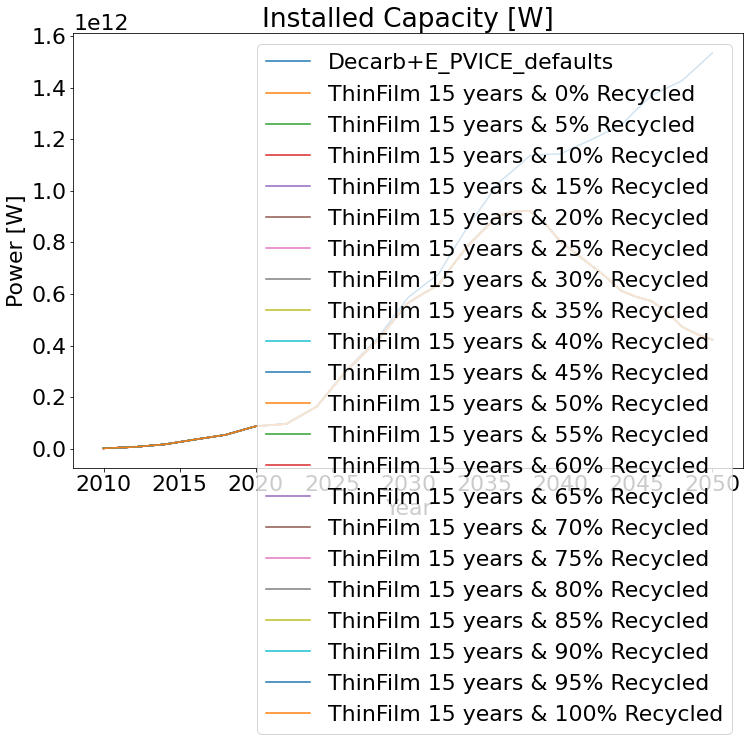

In [23]:
r3.plotScenariosComparison('Installed_Capacity_[W]')

In [ ]:
r3.plotMaterialComparisonAcrossScenarios(material='glass', keyword='mat_Total_Landfilled')

In [24]:
yearlythinfilmresults, cumthinfilmresults = r3.aggregateResults()
yearlythinfilmresults.to_csv(os.path.join(testfolder,'yearlythinfilmresults.csv'))
cumthinfilmresults.to_csv(os.path.join(testfolder,'cumthinfilmresults.csv'))

Now calculate installation compensation for the 15 year module.

In [158]:
for row in range (0,len(r3.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(r3.scenario.keys())):
        scen = list(r3.scenario.keys())[scenario]
        Under_Installment = ( (r3.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               r3.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        r3.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    r3.calculateMassFlow()

<ipython-input-158-b49200ee634b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r3.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment


Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 15% Recycled
********************

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  gl

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mate

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Materi

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glas

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  gl

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mate

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Materi

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glas

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Mater

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  ThinFilm 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames


In [159]:
yearlythinfilmresults_cc, cumthinfilmresults_cc = r3.aggregateResults()
yearlythinfilmresults_cc.to_csv(os.path.join(testfolder,'yearlythinfilmresults_cc.csv'))
cumthinfilmresults_cc.to_csv(os.path.join(testfolder,'cumthinfilmresults_cc.csv'))

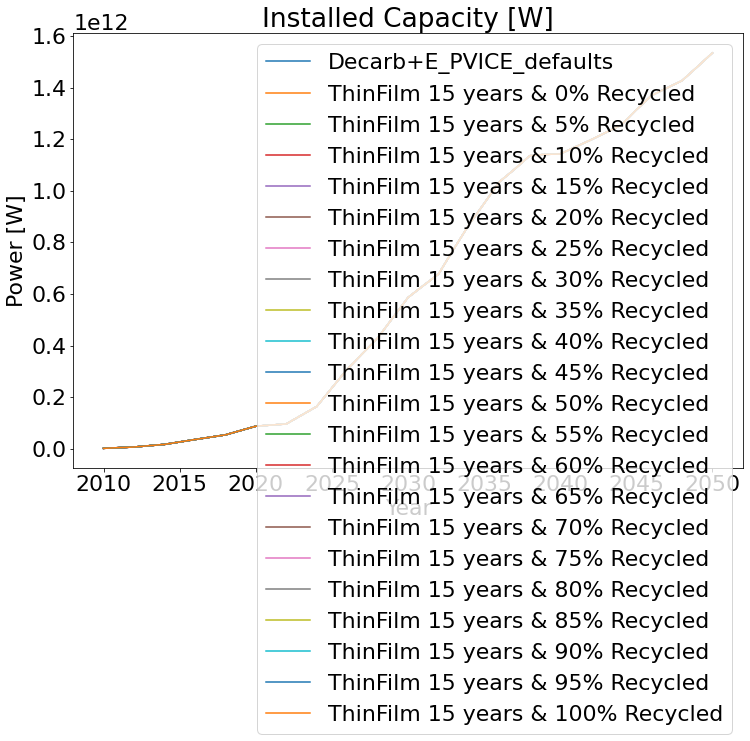

In [27]:
r3.plotScenariosComparison('Installed_Capacity_[W]')

Search for the cumulative value that is less/more than the PV ICE baseline with all materials.

In [160]:
#PV ICE all materials values
PVICE_virgin = cumRvL_identinstall.loc[2050]['VirginStock_Module_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]']/1e6
PVICE_waste = cumRvL_identinstall.loc[2050]['WasteAll_Module_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]']/1e6

print('PV ICE Baseline Values: \nVirgin Material Demand '
      +str(round(PVICE_virgin,2))+' million metric tonnes\n'+
     'Lifecycle Waste '+ str(round(PVICE_waste,2)) + ' million metric tonnes')

PV ICE Baseline Values: 
Virgin Material Demand 96.69 million metric tonnes
Lifecycle Waste 9.96 million metric tonnes


In [161]:
thinfilm_virginmod = pd.DataFrame(cumthinfilmresults_cc.loc[2050].filter(like='VirginStock_Module'))
thinfilm_virginmod[::-1]>=PVICE_virgin*1e6

,2050
VirginStock_Module_SanityCheck_ThinFilm 15 years & 100% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilm 15 years & 95% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilm 15 years & 90% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilm 15 years & 85% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilm 15 years & 80% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilm 15 years & 75% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilm 15 years & 70% Recycled_[Tonnes],True
VirginStock_Module_SanityCheck_ThinFilm 15 years & 65% Recycled_[Tonnes],True
VirginStock_Module_SanityCheck_ThinFilm 15 years & 60% Recycled_[Tonnes],True
VirginStock_Module_SanityCheck_ThinFilm 15 years & 55% Recycled_[Tonnes],True


Here, we compare the PV ICE c-Si virgin material demand to a thin film of 15 year life. These results indicate that lowering the BOM will lower the required closed-loop recycling rate to reduce virgin material demands from 95% to 75%.

In [162]:
thinfilm_waste = pd.DataFrame(cumthinfilmresults_cc.loc[2050].filter(like='WasteAll_Module'))
thinfilm_waste[::-1]>=PVICE_waste*1e6

,2050
WasteAll_Module_SanityCheck_ThinFilm 15 years & 100% Recycled_[Tonnes],False
WasteAll_Module_SanityCheck_ThinFilm 15 years & 95% Recycled_[Tonnes],False
WasteAll_Module_SanityCheck_ThinFilm 15 years & 90% Recycled_[Tonnes],False
WasteAll_Module_SanityCheck_ThinFilm 15 years & 85% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_ThinFilm 15 years & 80% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_ThinFilm 15 years & 75% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_ThinFilm 15 years & 70% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_ThinFilm 15 years & 65% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_ThinFilm 15 years & 60% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_ThinFilm 15 years & 55% Recycled_[Tonnes],True


This compares the thin film BOM waste to the PV ICE c-Si baseline waste. The recyling requirement for lowering waste is still quite high. Given that most of the waste is attributable to pre-2020 low open-loop recycleable modules, little can be done about the pre 2050 waste.

## Efficiency Modifcation

Now that we have confirmed that decreasing the mass per module area will lower the required closed-loop recycling rate, lets check that increasing module efficiency will have the same effect. Currently, PV ICE baseline is 20% efficiency in 2020 and 25% efficient in 2050. Oberbeck et al 2020 expect 30% efficient tandem devices (perovskite + silicon). Therefore, we will use this as an approximation of an efficiency increase, and will apply it to the 15 year module.

In [139]:
#create a subset of 15 year module with all recycling values
life15 = lifetime_range_df.iloc[0,:]

In [140]:
reff = PV_ICE.Simulation(name='SanityCheck', path=testfolder) #create simulation r1
#baselinefolder = r'..\baselines'    

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    reff.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    reff.scenario['Decarb+E_PVICE_defaults'].addMaterials(MATERIALS)  # baselinefolder=baselinefolder)
    reff.trim_Years(startYear=2010)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle
endYear not provided. Setting to end year of Module data 2050


In [141]:
for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
    scenname = 'Tandem 15 years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
    reff.createScenario(name=scenname,file=modulefile) #create the scenario with name
    reff.scenario[scenname].addMaterials(MATERIALS)  # baselinefolder=baselinefolder)
    reff.trim_Years(startYear=2010, endYear=2050)
    reff.modifyScenario(scenname, 'mod_lifetime', 15, 2020)
    reff.modifyScenario(scenname, 'mod_reliability_t50', float(life15['t50']), 2020)
    reff.modifyScenario(scenname, 'mod_reliability_t90', float(life15['t90']), 2020)
    reff.modifyScenario(scenname, 'mod_degradation', life15['mod_degradation'], 2020)
    reff.modifyScenario(scenname, 'mod_EOL_collected_recycled', 100.0, 2020)
    reff.modifyScenario(scenname, 'mod_EOL_collection_eff', 100.0, 2020)
    reff.modifyScenario(scenname, 'mod_eff', 30.0, 2020)
        
    for var in range(0,len(RecyclingPaths)):
        reff.scenario[scenname].modifyMaterials(MATERIALS, stage=RecyclingPaths[var], value=100.0, start_year=2020)
        
    for ylds in range(0,len(RecyclingYields)):
        reff.scenario[scenname].modifyMaterials(MATERIALS, stage=RecyclingYields[ylds], 
                                                  value=Recycling_Range[recycle], start_year=2020)

Text(0, 0.5, 'Module Efficiency [%]')

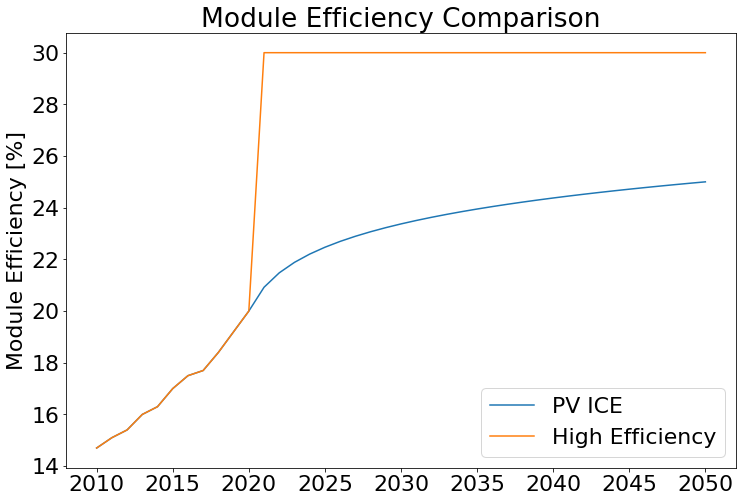

In [142]:
baselineeff = reff.scenario['Decarb+E_PVICE_defaults'].data['mod_eff']
tandemeff = reff.scenario['Tandem 15 years & 0% Recycled'].data['mod_eff']

mod_eff_compare_t = pd.DataFrame([baselineeff,tandemeff])
mod_eff_compare = mod_eff_compare_t.T
mod_eff_compare.index=range(2010,2051)
mod_eff_compare.columns = ('PV ICE','High Efficiency')
plt.plot(mod_eff_compare)
plt.title('Module Efficiency Comparison')
plt.legend(mod_eff_compare.columns)
plt.ylabel('Module Efficiency [%]')

In [143]:
reff.calculateMassFlow()

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silv

In [144]:
for row in range (0,len(reff.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(reff.scenario.keys())):
        scen = list(reff.scenario.keys())[scenario]
        Under_Installment = ( (reff.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               reff.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        reff.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    reff.calculateMassFlow()

<ipython-input-144-f34413646ab4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reff.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment


Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silv

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Tandem 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  enc

In [145]:
yearly_higheff_cc, cum_higheff_cc = reff.aggregateResults()
yearly_higheff_cc.to_csv(os.path.join(testfolder,'yearly_higheff_cc.csv'))
cum_higheff_cc.to_csv(os.path.join(testfolder,'cum_higheff_cc.csv'))

First we check the change in deployed capacity, since modifying module efficiency will primarily effect the deployment (and as a result effect virgin mateiral demand). Installs are only dependent on life, not recycling, therefore we can select any of the recycling rates.

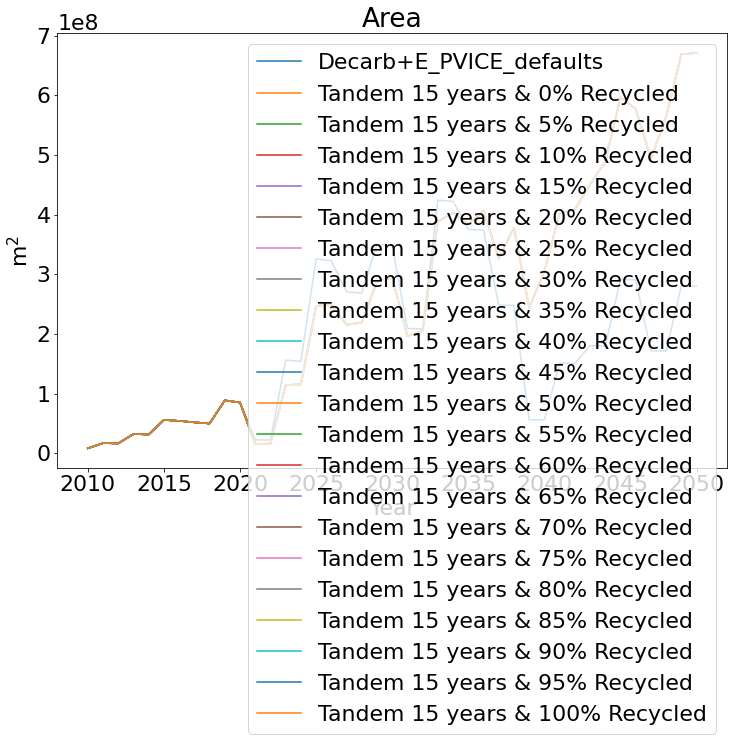

In [146]:
reff.plotScenariosComparison('Area')

Because we deploy using MW, the difference from efficiency improvement will not appear in MW deployed but in the area of those MW deployed. Therefore, we will compare the area deployed as a proxy for # of modules and compare the tandem 30% efficiency against the c-Si 25% efficiency 15 year modules, and PV ICE.

Text(0, 0.5, 'Area Deployed [m^2]')

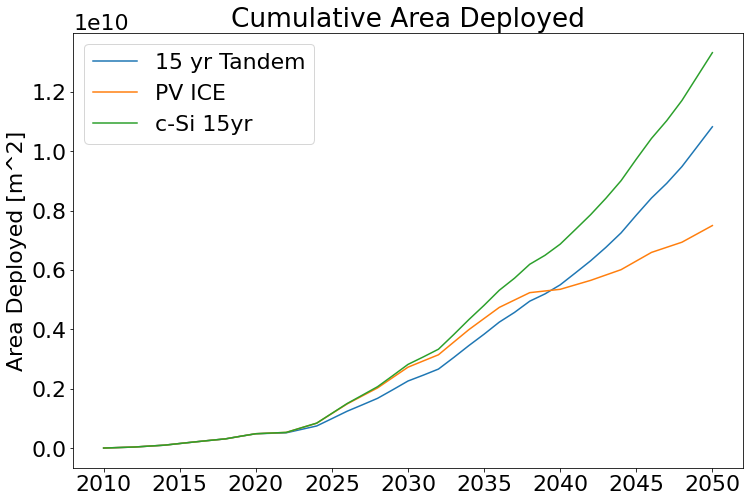

In [173]:
#'Area' is what gets installed annually, so cumcum = sum area installed
tandem_annualareainstalled = pd.Series(reff.scenario['Tandem 15 years & 0% Recycled'].data['Area'])
tandem_cumareainstalled = pd.Series(tandem_annualareainstalled.cumsum())

PVICE_annualareainstalled = pd.Series(reff.scenario['Decarb+E_PVICE_defaults'].data['Area'])
PVICE_cumareainstalled = PVICE_annualareainstalled.cumsum()

#the area deployed for the 15 yr BOM modified will be the same as the main analysis, because the eff is the same
#therefore, use r3 to get this number
cSi15yr_annualareainstalled = pd.Series(r3.scenario['ThinFilm 15 years & 0% Recycled'].data['Area'])
cSi15yr_cumareainstalled = cSi15yr_annualareainstalled.cumsum()

areacompare = pd.DataFrame([tandem_cumareainstalled, PVICE_cumareainstalled, cSi15yr_cumareainstalled], 
             index=['15 yr Tandem','PV ICE','c-Si 15yr'])
areacompare_df = areacompare.T
areacompare_df.index=range(2010,2051)

plt.plot(areacompare_df)
plt.legend(areacompare_df.columns)
plt.title('Cumulative Area Deployed')
plt.ylabel('Area Deployed [m^2]')

If we approximate a module as 1.6 m^2 (current average, though CdTe series 6 modules are 2.47 m^2), then we can use the area deployed to calculate an approximate number of modules.

In [183]:
modulesdeployed_millions = (areacompare_df/1.6)/1e6
modulesdeployed_millions.tail(1)

,15 yr Tandem,PV ICE,c-Si 15yr
2050,6765.070032,4686.505974,8324.399972


In [186]:
reducedmodules = modulesdeployed_millions.loc[2050,'c-Si 15yr']-modulesdeployed_millions.loc[2050,'15 yr Tandem']
modulesvspvice = modulesdeployed_millions.loc[2050,'15 yr Tandem']-modulesdeployed_millions.loc[2050,'PV ICE']
print('If module eff is 30%, then '+str(round(reducedmodules,2))+' million fewer modules can be deployed.')
print('However, the 15 year 30% effcient module still requires '+str(round(modulesvspvice,2))+
      ' million more modules than the 35 year 25% efficient module.')


If module eff is 30%, then 1559.33 million fewer modules can be deployed.
However, the 15 year 30% effcient module still requires 2078.56 million more modules than the 35 year 25% efficient module.


This graph shows the cumulative deployed area over time for the PV ICE baseline, the "15-year Tandem" device, which is the same BOM but higher module efficiency (30%), and the c-Si 15 year module with the same efficiency as PV ICE (25%). We see that the higher efficiency lowers the required deployment area. Interestingly, around 2038, PV ICE and the 15-year Tandem device cross, because the replacement requirement for the 15-year Tandem is higher than PV ICE 35 year module. Cumulatively, the Tandem device still requires more area deployment. Next let's look at what level of closed-loop recycling will drop the virgin material requirements.

In [188]:
tandem_virginmod = pd.DataFrame(cum_higheff_cc.loc[2050].filter(like='VirginStock_Module'))
tandem_virginmod[::-1]>=PVICE_virgin*1e6

,2050
VirginStock_Module_SanityCheck_Tandem 15 years & 100% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_Tandem 15 years & 95% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_Tandem 15 years & 90% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_Tandem 15 years & 85% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_Tandem 15 years & 80% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_Tandem 15 years & 75% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_Tandem 15 years & 70% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_Tandem 15 years & 65% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_Tandem 15 years & 60% Recycled_[Tonnes],True
VirginStock_Module_SanityCheck_Tandem 15 years & 55% Recycled_[Tonnes],True


These results indicate that due to reduced area deployed, the necessary closed-loop recycling is lowered to 65%. This indicates that virgin material demand is more sensitive to module efficiency than BOM (which lowered the closed-loop recycling need to 75%).

In [204]:
tandem_virginmod_millionmetrictonnes = tandem_virginmod/1e6
tandem_virginmod_millionmetrictonnes.loc['VirginStock_Module_SanityCheck_Tandem 15 years & 60% Recycled_[Tonnes]',2050]

96.83046243734402

In [57]:
tandem_wastemod = pd.DataFrame(cum_higheff_cc.loc[2050].filter(like='WasteAll_Module'))
tandem_wastemod[::-1]>=PVICE_waste*1e6

,2050
WasteAll_Module_SanityCheck_Tandem 15 years & 100% Recycled_[Tonnes],False
WasteAll_Module_SanityCheck_Tandem 15 years & 95% Recycled_[Tonnes],False
WasteAll_Module_SanityCheck_Tandem 15 years & 90% Recycled_[Tonnes],False
WasteAll_Module_SanityCheck_Tandem 15 years & 85% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_Tandem 15 years & 80% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_Tandem 15 years & 75% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_Tandem 15 years & 70% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_Tandem 15 years & 65% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_Tandem 15 years & 60% Recycled_[Tonnes],True
WasteAll_Module_SanityCheck_Tandem 15 years & 55% Recycled_[Tonnes],True


Like the BOM change, lifecycle wastes are not as sensitive to module efficiency changes, since much waste is due to pre-2020 modules. 

## Breakthrough Technology: Thin Film + High Efficiency

Finally, what if there is breakthrough technology which is 30% efficient and a thin film technology (i.e. low BOM).

In [127]:
r4 = PV_ICE.Simulation(name='SanityCheck', path=testfolder) #create simulation r1
#baselinefolder = r'..\baselines'    

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    r4.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    r4.scenario['Decarb+E_PVICE_defaults'].addMaterials(thinfilmMaterials)  # baselinefolder=baselinefolder)
    r4.trim_Years(startYear=2010)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle
endYear not provided. Setting to end year of Module data 2050


In [128]:
for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
    scenname = 'BkThru 15 years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
    r4.createScenario(name=scenname,file=modulefile) #create the scenario with name
    r4.scenario[scenname].addMaterials(thinfilmMaterials)  # baselinefolder=baselinefolder)
    r4.trim_Years(startYear=2010, endYear=2050)
    r4.modifyScenario(scenname, 'mod_lifetime', 15, 2020)
    r4.modifyScenario(scenname, 'mod_reliability_t50', float(life15['t50']), 2020)
    r4.modifyScenario(scenname, 'mod_reliability_t90', float(life15['t90']), 2020)
    r4.modifyScenario(scenname, 'mod_degradation', life15['mod_degradation'], 2020)
    r4.modifyScenario(scenname, 'mod_EOL_collected_recycled', 100.0, 2020)
    r4.modifyScenario(scenname, 'mod_EOL_collection_eff', 100.0, 2020)
    r4.modifyScenario(scenname, 'mod_eff', 30.0, 2020)
        
    for var in range(0,len(RecyclingPaths)):
        r4.scenario[scenname].modifyMaterials(thinfilmMaterials, stage=RecyclingPaths[var], value=100.0, start_year=2020)
        
    for ylds in range(0,len(RecyclingYields)):
        r4.scenario[scenname].modifyMaterials(thinfilmMaterials, stage=RecyclingYields[ylds], 
                                                  value=Recycling_Range[recycle], start_year=2020)

In [129]:
r4.calculateMassFlow()

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 15% Recycled
********************
Finishe

In [130]:
r4.scenario['BkThru 15 years & 5% Recycled'].data['mod_eff']

0     14.7
1     15.1
2     15.4
3     16.0
4     16.3
5     17.0
6     17.5
7     17.7
8     18.4
9     19.2
10    20.0
11    30.0
12    30.0
13    30.0
14    30.0
15    30.0
16    30.0
17    30.0
18    30.0
19    30.0
20    30.0
21    30.0
22    30.0
23    30.0
24    30.0
25    30.0
26    30.0
27    30.0
28    30.0
29    30.0
30    30.0
31    30.0
32    30.0
33    30.0
34    30.0
35    30.0
36    30.0
37    30.0
38    30.0
39    30.0
40    30.0
Name: mod_eff, dtype: float64

Now run capacity compensation. This is where the difference really lies, in how many fewer modules can be deployed due to increased module efficiency.

In [131]:
for row in range (0,len(r4.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(r4.scenario.keys())):
        scen = list(r4.scenario.keys())[scenario]
        Under_Installment = ( (r4.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               r4.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        r4.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    r4.calculateMassFlow()

<ipython-input-131-30c7c5b2eec1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r4.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment


Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 15% Recycled
********************
Finishe

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==>

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
=

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  gla

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==>

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
=

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  gla

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  g

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
Working on Scenario:  BkThru 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames


In [132]:
yearly_bkthru_cc, cum_bkthru_cc = r4.aggregateResults()
yearly_bkthru_cc.to_csv(os.path.join(testfolder,'yearly_bkthru_cc.csv'))
cum_bkthru_cc.to_csv(os.path.join(testfolder,'cum_bkthru_cc.csv'))

The reduction in area deployed should be identical to the module efficiency improvement analysis above. Therefore, we will just look at the combined effect on virigin material demand and the necessary closed-loop recycling rate.

In [133]:
bkthru_virginmod = pd.DataFrame(cum_bkthru_cc.loc[2050].filter(like='VirginStock_Module'))
bkthru_virginmod[::-1]>=PVICE_virgin*1e6

,2050
VirginStock_Module_SanityCheck_BkThru 15 years & 100% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_BkThru 15 years & 95% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_BkThru 15 years & 90% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_BkThru 15 years & 85% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_BkThru 15 years & 80% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_BkThru 15 years & 75% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_BkThru 15 years & 70% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_BkThru 15 years & 65% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_BkThru 15 years & 60% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_BkThru 15 years & 55% Recycled_[Tonnes],False


The combined lower BOM and higher Efficiency reduce the required circularity to 50% closed-loop.

## ALTERNATE BOM MODIFICATION

In this BOM modification, we will try to more accurately represent a thin film technology. Parameters will be identical glass baseline, Aluminum Frame, Backsheet, 10% of the c-Si, 50% of the encapsulant, and neglect Ag and Cu. The glass and backsheet baselines account for increasing shares of glass-glass packaging. Silicon absorber will be reduced to a thin film thickness as a proxy, and the encapsulant will be cut in half, since typically, thin film uses 1 sheet of encapsulant instead of the 2 sheets c-Si uses. This will include manufacturing inefficiencies of these materials. Current wafer thickness is ~165 micron, and CdTe thin films are 10s of microns; therefore we will use 10% of c-Si mass per area.

In [107]:
thinfilmBOM = ['glass','backsheet','aluminium_frames','silicon','encapsulant']
#create a subset of 15 year module with all recycling values
life15 = lifetime_range_df.iloc[0,:]

In [108]:
r5 = PV_ICE.Simulation(name='SanityCheck', path=testfolder) #create simulation r1
#baselinefolder = r'..\baselines'    

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    r5.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    r5.scenario['Decarb+E_PVICE_defaults'].addMaterials(thinfilmBOM)  # baselinefolder=baselinefolder)
    r5.trim_Years(startYear=2010)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle
endYear not provided. Setting to end year of Module data 2050


In [109]:
for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
    scenname = 'ThinFilmBOM 15 years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
    r5.createScenario(name=scenname,file=modulefile) #create the scenario with name
    r5.scenario[scenname].addMaterials(thinfilmBOM)  # baselinefolder=baselinefolder)
    r5.trim_Years(startYear=2010, endYear=2050)
    r5.modifyScenario(scenname, 'mod_lifetime', 15, 2020)
    r5.modifyScenario(scenname, 'mod_reliability_t50', float(life15['t50']), 2020)
    r5.modifyScenario(scenname, 'mod_reliability_t90', float(life15['t90']), 2020)
    r5.modifyScenario(scenname, 'mod_degradation', life15['mod_degradation'], 2020)
    r5.modifyScenario(scenname, 'mod_EOL_collected_recycled', 100.0, 2020)
    r5.modifyScenario(scenname, 'mod_EOL_collection_eff', 100.0, 2020)
        
    for var in range(0,len(RecyclingPaths)):
        r5.scenario[scenname].modifyMaterials(thinfilmBOM, stage=RecyclingPaths[var], value=100.0, start_year=2020)
        
    for ylds in range(0,len(RecyclingYields)):
        r5.scenario[scenname].modifyMaterials(thinfilmBOM, stage=RecyclingYields[ylds], 
                                                  value=Recycling_Range[recycle], start_year=2020)

In [110]:
#Modify the silicon and encapsulant
scennames = pd.Series(r5.scenario.keys())

#create new mass series
selectyears = r1.scenario['Decarb+E_PVICE_defaults'].material['encapsulant'].materialdata['year']>2020
newmass_encap = r1.scenario['Decarb+E_PVICE_defaults'].material['encapsulant'].materialdata.loc[selectyears,'mat_massperm2']*0.5
newmass_si = r1.scenario['Decarb+E_PVICE_defaults'].material['silicon'].materialdata.loc[selectyears,'mat_massperm2']*0.1

#this will change the Decarb+PVICE baseline, but we compare to original data from above
for scen in scennames:
    r5.scenario[scen].modifyMaterials('encapsulant', stage='mat_massperm2', value = newmass_encap, start_year=2020)
    r5.scenario[scen].modifyMaterials('silicon', stage='mat_massperm2', value = newmass_si, start_year=2020)

Text(0, 0.5, 'grams per m2')

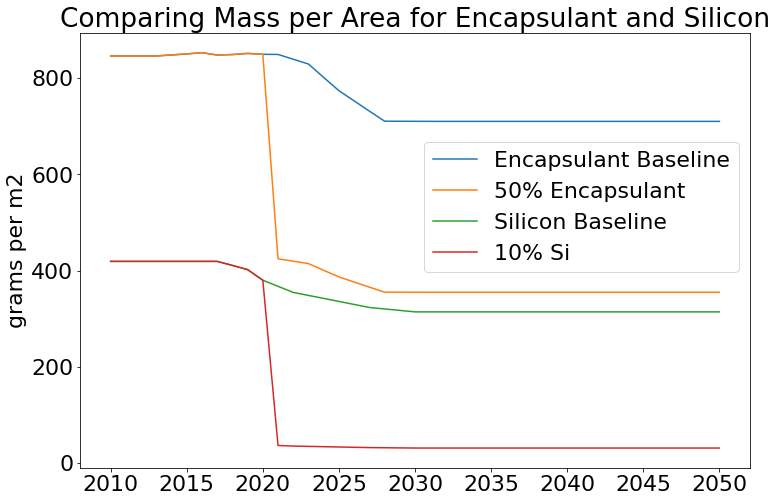

In [136]:
newsi = pd.Series(r5.scenario['Decarb+E_PVICE_defaults'].material['silicon'].materialdata['mat_massperm2'])
newencap = pd.Series(r5.scenario['Decarb+E_PVICE_defaults'].material['encapsulant'].materialdata['mat_massperm2'])
basesi = pd.Series(r1.scenario['Decarb+E_PVICE_defaults'].material['silicon'].materialdata['mat_massperm2'])
baseencap = pd.Series(r1.scenario['Decarb+E_PVICE_defaults'].material['encapsulant'].materialdata['mat_massperm2'])

compareBOM_t = pd.DataFrame([baseencap,newencap,basesi,newsi], 
                            index=('Encapsulant Baseline','50% Encapsulant','Silicon Baseline','10% Si'))
compareBOM = compareBOM_t.T
compareBOM.index=range(2010,2051)
plt.plot(compareBOM)
plt.legend(compareBOM.columns, loc='right', bbox_to_anchor=(0.5, 0.35, 0.5, 0.5))
plt.title('Comparing Mass per Area for Encapsulant and Silicon')
plt.ylabel('grams per m2')

In [112]:
r5.calculateMassFlow()

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 10% Recycled
********************
Fi

In [113]:
#Installation Compensation
for row in range (0,len(r5.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(r5.scenario.keys())):
        scen = list(r5.scenario.keys())[scenario]
        Under_Installment = ( (r5.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               r5.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        r5.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    r5.calculateMassFlow()

<ipython-input-113-7d616d1bfe65>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r5.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment


Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 10% Recycled
********************
Fi

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Materia

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
=

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Materia

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  backsheet
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  encapsulant
Working on Scenario:  ThinFilmBOM 15 years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material

In [114]:
yearly_thinfilmbom_cc, cum_thinfilmbom_cc = r5.aggregateResults()
yearly_thinfilmbom_cc.to_csv(os.path.join(testfolder,'yearly_thinfilmbom_cc.csv'))
cum_thinfilmbom_cc.to_csv(os.path.join(testfolder,'cum_thinfilmbom_cc.csv'))

Now we analyze the results

In [138]:
thinfilmBOM_virginmod = pd.DataFrame(cum_thinfilmbom_cc.loc[2050].filter(like='VirginStock_Module'))
thinfilmBOM_virginmod[::-1]>=PVICE_virgin*1e6

,2050
VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 100% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 95% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 90% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 85% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 80% Recycled_[Tonnes],False
VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 75% Recycled_[Tonnes],True
VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 70% Recycled_[Tonnes],True
VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 65% Recycled_[Tonnes],True
VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 60% Recycled_[Tonnes],True
VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 55% Recycled_[Tonnes],True


In [205]:
thinfilmBOM_virginmod_millionmetrictonnes = thinfilmBOM_virginmod/1e6
thinfilmBOM_virginmod_millionmetrictonnes.loc['VirginStock_Module_SanityCheck_ThinFilmBOM 15 years & 80% Recycled_[Tonnes]',2050]

94.326331330531

In [224]:
#comparison, c-si full BOM, 15-yr 80% recycled
cumRvL_installcomp.filter(regex='VirginStock_Module_').filter(like='15years').filter(like='80%').loc[2050]/1e6

VirginStock_Module_SF-LvR_15years & 80% Recycled_[Tonnes]    99.658599
Name: 2050, dtype: float64

These results indicate that 80% closed-loop recycling is required for this thin film BOM to extract fewer materials. This is an overall lowering of the BOM by:

In [241]:
matdf = pd.DataFrame()
for mat in thinfilmBOM:
    matdf[mat]=r5.scenario['ThinFilmBOM 15 years & 80% Recycled'].material[mat].materialdata['mat_massperm2']

matdf.index=range(2010,2051)
matdf['module'] = matdf.sum(axis=1)
matdf.tail(1)

,glass,backsheet,aluminium_frames,silicon,encapsulant,module
2050,10120.275,280.83,1143.529412,31.429855,355.058,11931.122267


In [242]:
pvicematdf = pd.DataFrame()
for mat in MATERIALS:
    pvicematdf[mat]=r1.scenario['Decarb+E_PVICE_defaults'].material[mat].materialdata['mat_massperm2']

pvicematdf.index=range(2010,2051)
pvicematdf['module'] = matdf.sum(axis=1)
pvicematdf.tail(1)

,glass,aluminium_frames,silicon,silver,copper,encapsulant,backsheet,module
2050,10120.275,1143.529412,314.29855,1.856311,6.84544,710.116,280.83,23862.244534


In [244]:
thinfilmfractionBOM = matdf.loc[2050,'module']/pvicematdf.loc[2050,'module']
print('The thin film BOM is '+str(thinfilmfractionBOM*100)+'% of the PV ICE BOM')

The thin film BOM is 50.0% of the PV ICE BOM
